
Exact-match accuracy (per rubric) + overall (all 4 must match):

        accuracy completeness relevance clarity all_4_match
setting                                                    
all        62.5%        59.5%     45.0%   47.5%       23.5%
each       41.0%        43.0%     45.0%   45.0%        9.0%
sixty      54.0%        51.0%     45.0%   47.5%       18.0%


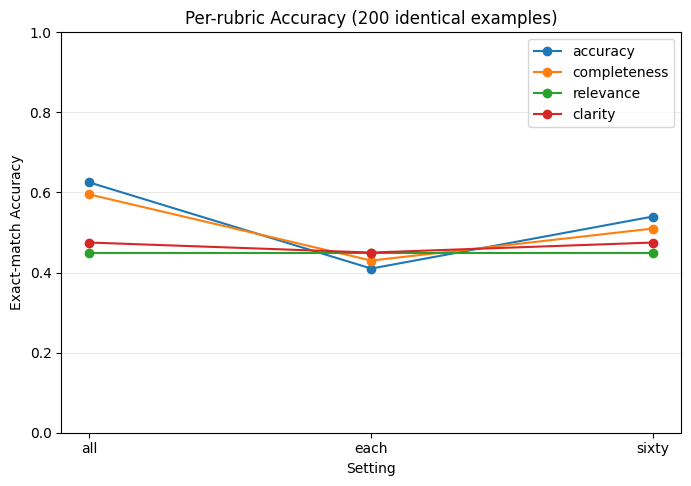

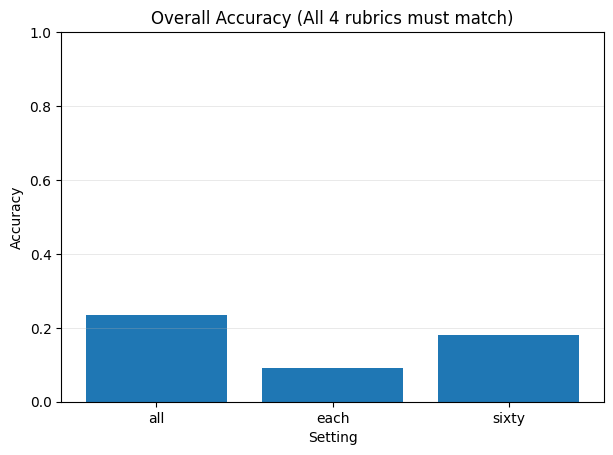

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# INPUT FILES (200 identical examples)
# ----------------------------
GT_PATH = "Codellama_groundtruth_identical_200.csv"

MODEL_FILES = {
    "all":   "cl_cot_all_200.csv",
    "each":  "cl_cot_each_200_aligned.csv",
    "sixty": "cl_cot_sixty_200_aligned.csv",
}

KEYS = ["code", "question"]
RUBRICS = ["accuracy", "completeness", "relevance", "clarity"]

# ----------------------------
# Helpers
# ----------------------------
def find_gt_col(df: pd.DataFrame, rubric: str) -> str:
    """
    Tries common ground-truth column patterns.
    Returns the best matching column name, or raises if none found.
    """
    candidates = [
        f"{rubric}_score",     # if you flattened earlier
        f"{rubric}.score",     # json_normalize often produces this
        rubric,                # sometimes already numeric
    ]
    for c in candidates:
        if c in df.columns:
            return c
    # also allow any column that ends with ".score" and starts with rubric
    for c in df.columns:
        if c.lower() == f"{rubric}.score".lower():
            return c
    raise KeyError(f"Couldn't find GT column for rubric='{rubric}'. Available cols: {list(df.columns)}")

def compute_rubric_accuracies(model_df: pd.DataFrame, gt_df: pd.DataFrame) -> dict:
    """
    Align by KEYS and compute exact-match accuracy for each rubric,
    plus overall accuracy where all 4 rubrics match.
    """
    aligned = model_df.merge(gt_df, on=KEYS, how="left", suffixes=("_model", "_gt"))

    out = {}

    # Per-rubric exact match accuracy
    match_cols = []
    for r in RUBRICS:
        model_col = r  # in cl_cot_* files rubric columns are named directly
        gt_col = find_gt_col(aligned, r)

        # numeric compare to avoid "4" vs 4.0 mismatch
        aligned[model_col] = pd.to_numeric(aligned[model_col], errors="coerce")
        aligned[gt_col] = pd.to_numeric(aligned[gt_col], errors="coerce")

        valid = aligned[gt_col].notna()
        acc = (aligned.loc[valid, model_col] == aligned.loc[valid, gt_col]).mean()
        out[r] = acc

        mc = f"match_{r}"
        aligned[mc] = valid & (aligned[model_col] == aligned[gt_col])
        match_cols.append(mc)

    # Overall: all 4 rubrics must match (only on rows where all GT rubrics exist)
    gt_cols = [find_gt_col(aligned, r) for r in RUBRICS]
    valid_all = aligned[gt_cols].notna().all(axis=1)
    out["all_4_match"] = (valid_all & aligned[match_cols].all(axis=1)).mean()

    return out

# ----------------------------
# Load data
# ----------------------------
gt = pd.read_csv(GT_PATH)

# ----------------------------
# Compute accuracies for each setting
# ----------------------------
rows = []
for setting, path in MODEL_FILES.items():
    model = pd.read_csv(path)

    # (optional sanity check) ensure same 200 examples
    # print(setting, len(model))

    metrics = compute_rubric_accuracies(model, gt)
    metrics["setting"] = setting
    rows.append(metrics)

summary = pd.DataFrame(rows).set_index("setting")[RUBRICS + ["all_4_match"]]
print("\nExact-match accuracy (per rubric) + overall (all 4 must match):\n")
print((summary * 100).round(2).astype(str) + "%")

# ----------------------------
# Graph 1: Line chart for per-rubric accuracy (like earlier)
# ----------------------------
x_labels = list(MODEL_FILES.keys())  # ["all","each","sixty"] in dict order
# If you want a specific order, set explicitly:
# x_labels = ["each", "sixty", "all"]

x = np.arange(len(x_labels))

plt.figure(figsize=(8, 5.2))
for r in RUBRICS:
    plt.plot(x, summary.loc[x_labels, r].values, marker="o", label=r)

plt.xticks(x, x_labels)
plt.ylim(0, 1)
plt.xlabel("Setting")
plt.ylabel("Exact-match Accuracy")
plt.title("Per-rubric Accuracy (200 identical examples)")
plt.grid(True, axis="y", linewidth=0.5, alpha=0.4)
plt.legend()
plt.show()

# ----------------------------
# Graph 2 (optional): Overall accuracy where all 4 match (bar chart)
# ----------------------------
plt.figure(figsize=(7, 4.8))
plt.bar(x_labels, summary.loc[x_labels, "all_4_match"].values)
plt.ylim(0, 1)
plt.xlabel("Setting")
plt.ylabel("Accuracy")
plt.title("Overall Accuracy (All 4 rubrics must match)")
plt.grid(True, axis="y", linewidth=0.5, alpha=0.4)
plt.show()
